# Strategies

This notebook aims to test a neural network using different word embedding methods.

**Word embedding methods:**

| Method       | Definition                                                                 | Advantages                                                                                     | Limitations                                                                 |
|--------------|-----------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| Word2Vec     | Represents words as dense vectors in a continuous space, capturing semantic relationships based on context. | Effective for capturing semantic relationships; widely used in NLP tasks.                     | Requires large datasets; struggles with out-of-vocabulary words.            |
| Glove        | Generates word embeddings by factorizing a co-occurrence matrix, capturing both local and global semantic relationships. | Captures both local and global context; effective for text classification and sentiment analysis. | Computationally expensive; requires pre-computed co-occurrence statistics.  |
| USE (Universal Sentence Encoder) | Produces embeddings for entire sentences rather than individual words, leveraging deep learning models. | Captures sentence-level semantics; pre-trained models available for quick use.                | Higher computational cost; less effective for word-level tasks.             |
| BERT |  |                 |              |

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import time
import warnings
from collections import Counter
import pickle
from tqdm import tqdm

# NLTK
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

# scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             fbeta_score, make_scorer, matthews_corrcoef, balanced_accuracy_score,
                             classification_report, confusion_matrix, roc_auc_score, roc_curve)


import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Add Hugging Face transformers for BERT
# try:
#     from transformers import BertTokenizer, TFBertModel
# except ImportError:
#     print("Installing transformers library...")
#     import sys
#     !{sys.executable} -m pip install transformers
#     from transformers import BertTokenizer, TFBertModel

print("Version:", tf.__version__)
print("GPU disponible :", tf.config.list_physical_devices('GPU'))


import mlflow
import mlflow.keras


plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'DejaVu Sans'
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ikusawalaetitia/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ikusawalaetitia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ikusawalaetitia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Version: 2.16.2
GPU disponible : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', True)

# Data preparation

## Import

In [3]:
path_to_sample = "../data/processed_sample_tweets.csv"

sample_df = pd.read_csv(path_to_sample, encoding='utf-8')
# Display the first few rows of the dataframe
sample_df.head(10)

,target,ids,date,user,text,processed_text_lem,advanced_processed_text_lem,processed_text_stem,advanced_processed_text_stem
0,0,2065378704,2009-06-07 08:28:25,juliaindelicate,@christt I really wanted to go i didn't get t...,< mention > really wanted go not get go anal b...,< mention > really wanted go not get go anal b...,< mention > realli want go not get go ani anal...,< mention > realli want go not get go ani anal...
1,0,2198776518,2009-06-16 16:33:19,hxcfairy,Finally home from my sisters and I'm so tired,finally home sister tired,finally home sister tired,final home sister tire,final home sister tire
2,0,2258118867,2009-06-20 15:24:59,TranceGemini613,"I really, really wish I'd known all the stuff ...",really really wish would known stuff james tel...,really really wish would known stuff james tel...,realli realli wish would known stuff jame tell...,realli realli wish would known stuff jame tell...
3,0,1755733793,2009-05-10 09:53:26,jwatkins5377,Can officially say I have been at work EVERYDA...,officially say work everyday week ... bad toda...,officially say work everyday week ... bad toda...,offici say work everyday thi week ... bad toda...,offici say work everyday thi week ... bad toda...
4,0,1881082418,2009-05-22 03:32:26,davelee,#FirstRecord The Mr Blobby single Sorry folks.,< hashtag > mr blobby single sorry folk .,< hashtag > mr lobby single sorry folk .,< hashtag > mr blobbi singl sorri folk .,< hashtag > mr lobbi singl sorri folk .
5,0,2045678642,2009-06-05 11:04:38,johnny101,My turkey and ham salad wrap is not sitting we...,turkey ham salad wrap not sitting well .,turkey ham salad wrap not sitting well .,turkey ham salad wrap not sit well .,turkey ham salad wrap not sit well .
6,0,2323712552,2009-06-25 01:17:50,Matt_Whiting,Footy Trainin Was called off Now i Dont kn...,footy trainin wa called dont know ? laugh loud,footy training wa called not know ? lot,footi trainin wa call dont know ? laugh loud,footi train wa call not know ? lot
7,0,2200119346,2009-06-16 18:27:54,JoePaley17,Just got bacl from ftbl summer school tomorrow,got bacl ftbl summer school tomorrow,got back feel summer school tomorrow,got bacl ftbl summer school tomorrow,got back feel summer school tomorrow
8,0,2247872282,2009-06-19 19:45:15,trexsandwich,"@writesfortea Cool teachers are the best, but ...",< mention > cool teacher best never lasted sch...,< mention > cool teacher best never lasted sch...,< mention > cool teacher best never last schoo...,< mention > cool teacher best never last schoo...
9,0,1835988160,2009-05-18 07:09:13,renzzee,"@rediska08 awts. friday, parteeey! hahaha! sa...",< mention > awts . friday parteey ! hahaha ! s...,< mention > awts . friday parteey ! hahaha ! s...,< mention > awt . friday parteey ! hahaha ! sa...,< mention > awt . friday parteey ! hahaha ! sa...


## Split

In [4]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X_lem = sample_df['processed_text_lem']
X_stem = sample_df['processed_text_stem']

y = sample_df['target']

# Split the data into training, testing and validation sets
X_temp_lem, X_test_lem, y_temp_lem, y_test_lem = train_test_split(
    X_lem, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
X_train_lem, X_val_lem, y_train_lem, y_val_lem = train_test_split(
    X_temp_lem, y_temp_lem,
    test_size=0.25,  # 0.25 x 0.8 = 0.2
    random_state=42,
    stratify=y_temp_lem
)

# Display the shapes of the resulting datasets
print(f"X_train_lem shape: {X_train_lem.shape}")
print(f"X_test_lem shape: {X_test_lem.shape}")
print(f"y_train_lem shape: {y_train_lem.shape}")
print(f"y_test_lem shape: {y_test_lem.shape}")


# Split the data into training and testing sets
X_temp_stem, X_test_stem, y_temp_stem, y_test_stem = train_test_split(
    X_stem, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
X_train_stem, X_val_stem, y_train_stem, y_val_stem = train_test_split(
    X_temp_stem, y_temp_stem,
    test_size=0.25,  # 0.25 x 0.8 = 0.2
    random_state=42,
    stratify=y_temp_stem
)


# Display the shapes of the resulting datasets
print(f"X_train_stem shape: {X_train_stem.shape}")
print(f"X_val_stem shape: {X_val_stem.shape}")
print(f"X_test_stem shape: {X_test_stem.shape}")
print(f"y_train_stem shape: {y_train_stem.shape}")
print(f"X_val_stem shape: {X_val_stem.shape}")
print(f"y_test_stem shape: {y_test_stem.shape}")

X_train_shape = X_train_lem.shape
X_val_shape = X_val_lem.shape
X_test_shape = X_test_lem.shape

X_train_lem shape: (30000,)
X_test_lem shape: (10000,)
y_train_lem shape: (30000,)
y_test_lem shape: (10000,)
X_train_stem shape: (30000,)
X_val_stem shape: (10000,)
X_test_stem shape: (10000,)
y_train_stem shape: (30000,)
X_val_stem shape: (10000,)
y_test_stem shape: (10000,)


## MLFlow setup

In [5]:
import os
from dotenv import load_dotenv
import time

import mlflow
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient


from tqdm import tqdm


# For scikit-learn
mlflow.sklearn.autolog()

# Configuring MLflow
load_dotenv()
tracking_uri = os.getenv("MLFLOW_TRACKING_URI")
mlflow.set_tracking_uri(tracking_uri)
print(f"MLflow Tracking URI: {tracking_uri}")

MLflow Tracking URI: http://localhost:8080


In [6]:
# Create a new MLflow Experiment
experiment_name = "P7-Sentiments_Analysis_neural_network"

# Check if the experiment exists, create it if it doesn't
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"Created new experiment '{experiment_name}' with ID: {experiment_id}")
else:
    experiment_id = experiment.experiment_id
    print(f"Using existing experiment '{experiment_name}' with ID: {experiment_id}")

# Set the experiment
mlflow.set_experiment(experiment_name)

Using existing experiment 'P7-Sentiments_Analysis_neural_network' with ID: 915290206608231433


<Experiment: artifact_location='mlflow-artifacts:/915290206608231433', creation_time=1758900314087, experiment_id='915290206608231433', last_update_time=1758900314087, lifecycle_stage='active', name='P7-Sentiments_Analysis_neural_network', tags={}>

# Functions

## Helpers

In [44]:
def plot_learning_curves(history, model_name):
    """
    Plots training and validation learning curves and saves them to MLflow.

    Args:
        history: History object returned by model.fit()
        model_name: Name of the model for labeling the plots
    """
    # Create a figure with two subplots (loss and accuracy)
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Add tight layout to make sure plots don't overlap
    plt.tight_layout()

    # Save the figure locally
    learning_curve_path = f"learning_curve_{model_name}.png"
    plt.savefig(learning_curve_path)

    # Log the figure to MLflow
    mlflow.log_artifact(learning_curve_path)

    # Close the figure to free memory
    plt.close()

    print(f"Learning curves for {model_name} saved and logged to MLflow")

In [46]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Creates and saves a confusion matrix visualization.

    Args:
        y_true: True labels
        y_pred: Predicted labels (should be binary 0/1 values, not probabilities)
        model_name: Name of the model for labeling
    """
    # Convert predictions to binary labels if they're probabilities
    if isinstance(y_pred[0], (np.float32, np.float64)):
        y_pred_binary = (y_pred > 0.5).astype(int)
    else:
        y_pred_binary = y_pred

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred_binary)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
    plt.yticks([0.5, 1.5], ['Negative', 'Positive'])

    # Save the figure
    cm_path = f"confusion_matrix_{model_name}.png"
    plt.savefig(cm_path)

    # Log to MLflow
    mlflow.log_artifact(cm_path)

    # Close the figure
    plt.close()

    print(f"Confusion matrix for {model_name} saved and logged to MLflow")

In [45]:
def log_metrics_summary_table(metrics, dataset_type, embedding_type):
    """
    Creates and logs a detailed metrics summary table as a CSV file.

    Args:
        metrics: Dictionary of evaluation metrics
        dataset_type: 'validation' or 'test'
        embedding_type: Type of embedding used (w2v, fasttext, glove)
    """
    # Create a DataFrame from the metrics dictionary
    metrics_df = pd.DataFrame([metrics])

    # Add embedding type and dataset information
    metrics_df['embedding'] = embedding_type
    metrics_df['dataset'] = dataset_type

    # Save as CSV
    csv_path = f"{dataset_type}_metrics_{embedding_type}.csv"
    metrics_df.to_csv(csv_path, index=False)

    # Log to MLflow
    mlflow.log_artifact(csv_path)

    return metrics_df

## Classes

In [7]:
class TweetVectorizer:
    def __init__(self, preprocessor: str = None, vectoriser: str = 'w2v'):
        self.preprocessor = preprocessor
        self.vectoriser = vectoriser
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()

        # Initialize vectorizers
        if vectoriser == 'w2v':
            from gensim.models import Word2Vec
            self.model = None # Will be initialized during fit
        elif vectoriser == 'fasttext':
            from gensim.models import FastText
            self.model = FastText(vector_size=100, window=5, min_count=1, workers=4)
        elif vectoriser == 'glove':
            self.model = None  # Will be loaded from gensim-data when needed
        elif vectoriser == 'use':
            import tensorflow_hub as hub
            self.model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
        elif vectoriser == 'bert':
            # Initialize BERT tokenizer and model
            from transformers import BertTokenizer, TFBertModel
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            self.model = TFBertModel.from_pretrained('bert-base-uncased')
        else:
            raise ValueError("Unsupported vectoriser. Choose from 'w2v', 'fasttext', 'glove', 'use', or 'bert'.")

    def preprocess(self, text: str) -> str:
        """
        Cleans and preprocesses a single text string by replacing URLs, mentions, and hashtags,
        converting to lowercase, removing special characters, and removing stopwords.

        Args:
            text (str): The text string to process.

        Returns:
            str: The processed text string.
        """


        if pd.isna(text):
            return ""
        # Replace URLs with <URL>
        processed = re.sub(r'https?://\S+', '<URL>', text)
        # Replace mentions with <MENTION>
        processed = re.sub(r'@[A-Za-z0-9_]+', '<MENTION>', processed)
        # Separate # from word and replace the word with <HASHTAG>
        processed = re.sub(r'#([A-Za-z0-9_]+)', r'#<HASHTAG>', processed)

        # Convert text to lowercase
        processed = processed.lower()

        # Remove special characters and numbers, keeping !, ?, and ellipsis (...)
        # Also keeps the placeholders <URL>, <MENTION>, <HASHTAG>
        processed = re.sub(r'[^a-z0-9\s.!?<>#]', '', processed)

        # Tokenize the text
        tokens = word_tokenize(processed)

        # Initialize lemmatizer
        if self.preprocessor == 'lemmatization':
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        # Initialize stemmer
        if self.preprocessor == 'stemming':
            tokens = [self.stemmer.stem(token) for token in tokens]


        # Define negative words that should not be removed
        negative_words = {
            'no', 'not', 'nor', "don't", "aren't", "couldn't", "didn't", "doesn't",
            "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't",
            "needn't", "shan't", "shouldn't", "wasn't", "weren't", "won't", "wouldn't",
            "never", "none", "nobody", "nothing", "nowhere", "neither"
        }
        # Create a set of stopwords to remove, excluding the negative words
        stop_words_to_remove = set(stopwords.words('english')) - negative_words

        # remove stopwords, and join back to string
        filtered_tokens = [word for word in tokens if word not in stop_words_to_remove]

        return ' '.join(filtered_tokens)

    def fit_transform(self, texts: pd.Series):
        """
        Fits the vectorizer model (if applicable) and transforms the input texts into vectors.

        Args:
            texts (pd.Series): Series of text strings to fit and transform.

        Returns:
            np.ndarray: Array of vectorized texts.
        """
        processed_texts = texts.apply(self.preprocess).tolist()

        if self.vectoriser == 'w2v':
            from gensim.models import Word2Vec
            tokenized_texts = [text.split() for text in processed_texts]
            self.model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)
            vectors = np.array([np.mean([self.model.wv[word] for word in text.split() if word in self.model.wv] or [np.zeros(100)], axis=0) for text in processed_texts])
        elif self.vectoriser == 'glove':
            import gensim.downloader as api
            if self.model is None:
                self.model = api.load("glove-twitter-100")
            vectors = np.array([np.mean([self.model[word] for word in text.split() if word in self.model] or [np.zeros(100)], axis=0) for text in processed_texts])
        elif self.vectoriser == 'fasttext':
            tokenized_texts = [text.split() for text in processed_texts]
            self.model.build_vocab(tokenized_texts, update=True)
            self.model.train(tokenized_texts, total_examples=len(tokenized_texts), epochs=self.model.epochs)
            vectors = np.array([np.mean([self.model.wv[word] for word in text.split() if word in self.model.wv] or [np.zeros(100)], axis=0) for text in processed_texts])
        # elif self.vectoriser == 'bert':

        elif self.vectoriser == 'bert':
            # For BERT, we need to tokenize the text and return the encoded features
            # This returns a batch of token IDs, attention masks, and token type IDs
            encoded_inputs = self.tokenizer(
                processed_texts,
                padding='max_length',
                truncation=True,
                max_length=self.max_length,
                return_tensors='tf'
            )

            # Get BERT embeddings - using CLS token (first token) as the sentence representation
            outputs = self.model(encoded_inputs)
            # We'll use the CLS token (first token) embeddings as the sentence representation
            vectors = outputs.last_hidden_state[:, 0, :].numpy()  # Shape: (batch_size, hidden_size=768)
        else:
            raise ValueError("Unsupported vectoriser. Choose from 'w2v', 'fasttext', 'use', or 'bert'.")

        # Chech for 2D array
        if vectors.ndim == 1:
            vectors = vectors.reshape(-1, 1)
        elif vectors.ndim == 2 and vectors.shape[1] == 1:
            vectors = vectors.reshape(-1, vectors.shape[1])

        return vectors

    def transform(self, texts: pd.Series):
        """
        Transforms the input texts into vectors using the fitted vectorizer model.

        Args:
            texts (pd.Series): Series of text strings to transform.

        Returns:
            np.ndarray: Array of vectorized texts.
        """
        processed_texts = texts.apply(self.preprocess).tolist()

        if self.vectoriser == 'w2v':
            if self.model is None:
                raise ValueError("The Word2Vec model has not been fitted. Call fit_transform first.")
            vectors = np.array([np.mean([self.model.wv[word] for word in text.split() if word in self.model.wv] or [np.zeros(100)], axis=0) for text in processed_texts])
        elif self.vectoriser == 'fasttext':
            if self.model is None:
                raise ValueError("The FastText model has not been fitted. Call fit_transform first.")
            vectors = np.array([np.mean([self.model.wv[word] for word in text.split() if word in self.model.wv] or [np.zeros(100)], axis=0) for text in processed_texts])
        elif self.vectoriser == 'glove':
            import gensim.downloader as api
            if self.model is None:
                self.model = api.load("glove-twitter-100")
            vectors = np.array([np.mean([self.model[word] for word in text.split() if word in self.model] or [np.zeros(100)], axis=0) for text in processed_texts])
        elif self.vectoriser == 'use':
            vectors = self.model(processed_texts).numpy()
        elif self.vectoriser == 'bert':
            # For BERT, we need to tokenize the text and return the encoded features
            encoded_inputs = self.tokenizer(
                processed_texts,
                padding='max_length',
                truncation=True,
                max_length=self.max_length,
                return_tensors='tf'
            )

            # Get BERT embeddings - using CLS token (first token) as the sentence representation
            outputs = self.model(encoded_inputs)
            vectors = outputs.last_hidden_state[:, 0, :].numpy()  # Shape: (batch_size, hidden_size=768)
        else:
            raise ValueError("Unsupported vectoriser. Choose from 'w2v', 'fasttext', 'use', or 'bert'.")

        return vectors

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, SimpleRNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec, FastText
import os

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

class LSTMTweetClassifier:
    def __init__(self, embedding:str, embedding_dim: int, lstm_units: int=128, max_length: int = 100):
        self.embedding = embedding
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.max_length = max_length
        self.tokenizer = Tokenizer()
        self.model = None
        self.word_index = self.tokenizer.word_index
        self.model_dir = "../models"

    def build_embedding_matrix(self):
        if self.embedding == 'w2v':
            from gensim.models import Word2Vec
            embedding_model = Word2Vec.load(os.path.join(self.model_dir, "word2vec.model"))
        elif self.embedding == 'fasttext':
            from gensim.models import FastText
            embedding_model = FastText.load(os.path.join(self.model_dir, "fasttext.model"))
        elif self.embedding == 'glove':
            import gensim.downloader as api
            embedding_model = api.load("glove-twitter-100")
        else:
            raise ValueError("Unsupported embedding type. Choose 'w2v', 'fasttext', or 'glove'.")

        word_index = self.tokenizer.word_index
        vocab_size = len(word_index) + 1
        embedding_matrix = np.zeros((vocab_size, self.embedding_dim))

        for word, i in word_index.items():
            if self.embedding == 'glove':
                if word in embedding_model:
                    embedding_matrix[i] = embedding_model[word]
                else:
                    embedding_matrix[i] = np.random.normal(size=(self.embedding_dim,))
            else:  # For Word2Vec and FastText
                if word in embedding_model.wv:
                    embedding_matrix[i] = embedding_model.wv[word]
                else:
                    embedding_matrix[i] = np.random.normal(size=(self.embedding_dim,))

        return embedding_matrix

    def build_RNN_model(self, vocab_size: int, embedding_matrix: np.ndarray):
        model = Sequential()
        model.add(Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, weights=[embedding_matrix], input_length=100, trainable=False))
        model.add(SimpleRNN(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
        model.add(SimpleRNN(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))
        model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        self.model = model
        return model

    def build_LSTM_model(self, vocab_size: int, embedding_matrix: np.ndarray, bidirectionnal: bool):
        """Builds the LSTM model architecture.

        Args:
            vocab_size (int): Size of the vocabulary.
            embedding_matrix (np.ndarray): Pre-trained embedding matrix.
        Returns:
            keras.Model: Compiled LSTM model.
        """
        # Initialize the model
        model = Sequential()
        # Add embedding layer with pre-trained weights
        model.add(Embedding(input_dim=vocab_size,
                            output_dim=self.embedding_dim,
                            weights=[embedding_matrix],
                            input_length=self.max_length,
                            trainable=False))  # Freezing the embedding layer
        if bidirectionnal:
            # Add a Bidirectional LSTM layer
            model.add(Bidirectional(LSTM(self.lstm_units, return_sequences=False)))
        else:
            model.add(LSTM(self.lstm_units, return_sequences=False))
        # Add a Dense output layer with sigmoid activation for binary classification
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=0.001),
                      metrics=['accuracy'])

        self.model = model
        return model

    def get_metrics(self, y_true, y_pred):
        """Calculates and returns various classification metrics.

        Args:
            y_true (np.ndarray): True labels.
            y_pred (np.ndarray): Predicted labels.
        Returns:
            dict: Dictionary containing accuracy, precision, recall, f1-score, and MCC.
        """
        accuracy = np.mean((y_pred > 0.5).flatten() == y_true)
        specificity = np.sum((y_pred < 0.5).flatten() & (y_true == 0)) / np.sum(y_true == 0)
        auc = roc_auc_score(y_true, y_pred)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("specificity", specificity)
        mlflow.log_metric("auc", auc)
        return {
            'accuracy': accuracy,
            'specificity': specificity,
            'auc': auc
        }

    def train_and_evaluate(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        """Trains the LSTM model and evaluates it on the validation set.

        Args:
            X_train (np.ndarray): Training feature vectors.
            y_train (np.ndarray): Training labels.
            X_val (np.ndarray): Validation feature vectors.
            y_val (np.ndarray): Validation labels.
            epochs (int, optional): Number of training epochs. Defaults to 10.
            batch_size (int, optional): Batch size for training. Defaults to 32.
        Returns:
            dict: Dictionary containing evaluation metrics on the validation set.
        """
        if self.model is None:
            raise ValueError("The model has not been built. Call build_model first.")
        with mlflow.start_run(run_name=f"LSTM_{self.embedding}_{self.epochs}epochs_{self.lstm_units}units", nested= True):
            # log model parameters
            mlflow.log_param("embedding", self.embedding)
            mlflow.log_param("embedding_dim", self.embedding_dim)
            mlflow.log_param("lstm_units", self.lstm_units)
            mlflow.log_param("max_length", self.max_length)
            mlflow.log_param("epochs", epochs)
            mlflow.log_param("batch_size", batch_size)

            start_time = time.time()
            history = self.model.fit(X_train, y_train,
                                     validation_data=(X_val, y_val),
                                     epochs=epochs,
                                     batch_size=batch_size,
                                     verbose=1)
            training_time = time.time() - start_time
            mlflow.log_metric("training_time", training_time)

            # Log training and validation metrics for each epoch
            for epoch in range(epochs):
                mlflow.log_metric("train_loss", history.history['loss'][epoch], step=epoch)
                mlflow.log_metric("train_accuracy", history.history['accuracy'][epoch], step=epoch)
                mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
                mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)

            # Plot and save learning curves
            model_name = f"LSTM_{self.embedding}_{self.lstm_units}units"
            plot_learning_curves(history, model_name)

            # Evaluate on validation set
            start_prediction_time = time.time()
            y_val_pred = self.model.predict(X_val).flatten()
            prediction_time = time.time() - start_prediction_time
            mlflow.log_metric("prediction_time", prediction_time)

            # Calulate validation metrics
            val_metrics = {
                'accuracy': accuracy_score(y_val, (y_val_pred > 0.5).astype(int)),
                'precision': precision_score(y_val, (y_val_pred > 0.5).astype(int)),
                'recall': recall_score(y_val, (y_val_pred > 0.5).astype(int)),
                'f1_score': f1_score(y_val, (y_val_pred > 0.5).astype(int)),
                'specificity': np.sum(np.logical_and((y_val_pred < 0.5).flatten(), y_val == 0)) / np.sum(y_val == 0),
                'roc_auc': roc_auc_score(y_val, y_val_pred),
                'prediction_time': prediction_time
            }

            # Log metrics to MLflow
            for metric_name, metric_value in val_metrics.items():
                mlflow.log_metric(metric_name, metric_value)

            # Create and log detailed metrics summary
            val_metrics_df = log_metrics_summary_table(val_metrics, 'validation', self.embedding)

            # check if artifact folder exists

            # ROC AUC proba
            y_val_proba = self.model.predict(X_val).flatten()
            fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % val_metrics['roc_auc'])
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - LSTM with {self.embedding} Embeddings')
            plt.legend(loc="lower right")

            # Create the artifact directory if it doesn't exist
            os.makedirs("artifacts", exist_ok=True)
            roc_path = f"roc_curve_{self.embedding}.png"
            plt.savefig(roc_path)
            mlflow.log_artifact(roc_path)
            plt.close()

            # Create and log confusion matrix
            y_val_pred_binary = (y_val_pred > 0.5).astype(int)
            model_name = f"LSTM_{self.embedding}_{self.lstm_units}units"
            plot_confusion_matrix(y_val, y_val_pred_binary, model_name)

            # Log the model
            mlflow.keras.log_model(self.model, f"LSTM_{self.embedding}_{self.lstm_units}units_model")
            run_id = mlflow.active_run().info.run_id
            result= mlflow.register_model(f"runs:/{run_id}/LSTM_{self.embedding}_{self.lstm_units}units_model", f"LSTM_{self.embedding}_{self.lstm_units}units_model")

    def fit(self, text: pd.Series, labels: pd.Series, test_size:float = 0.2, val_split:float = 0.2,epochs: int=10, batch_size: int=32):
        # Tokenize and pad sequences
        self.tokenizer.fit_on_texts(text)
        sequences = self.tokenizer.texts_to_sequences(text)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_length, padding='post', truncating='post')

        vocab_size = len(self.tokenizer.word_index) + 1  # +1 for padding token

        # Build embedding matrix
        embedding_matrix = self.build_embedding_matrix()

        # Build the model
        self.build_model(vocab_size, embedding_matrix)

        # split the data into training/val and test sets
        X_temp, X_test, y_temp, y_test = train_test_split(
            padded_sequences, labels, test_size=test_size, random_state=42, stratify=labels
        )

        # Split into train set into train and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_split, random_state=42, stratify=y_temp)

        print(f"X_train shape: {X_train.shape}")
        print(f"X_val shape: {X_val.shape}")
        print(f"X_test shape: {X_test.shape}")

        # Train and evaluate the model
        self.epochs = epochs
        self.train_and_evaluate(X_train, y_train, X_val, y_val, epochs, batch_size)

        # Final evaluation on the test set
        y_test_pred = self.model.predict(X_test).flatten()
        test_metrics = self.get_metrics(y_test, y_test_pred)
        print("Test Metrics:", test_metrics)
        for metric_name, metric_value in test_metrics.items():
            mlflow.log_metric(f"test_{metric_name}", metric_value)

        # Create and log detailed metrics summary for test set
        test_metrics_df = log_metrics_summary_table(test_metrics, 'test', self.embedding)

        # Create and log confusion matrix for test set
        y_test_pred_binary = (y_test_pred > 0.5).astype(int)
        model_name = f"LSTM_{self.embedding}_{self.lstm_units}units_TEST"
        plot_confusion_matrix(y_test, y_test_pred_binary, model_name)

        # ROC Curve for test set
        fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
        plt.figure()
        plt.plot(fpr_test, tpr_test, color='blue', lw=2,
                label=f'ROC curve (area = {roc_auc_score(y_test, y_test_pred):.2f})')
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Test Set ROC - LSTM with {self.embedding} Embeddings')
        plt.legend(loc="lower right")
        test_roc_path = f"test_roc_curve_{self.embedding}.png"
        plt.savefig(test_roc_path)
        mlflow.log_artifact(test_roc_path)
        plt.close()

    def predict(self, texts: pd.Series):
        """Predicts the sentiment of the input texts.

        Args:
            texts (pd.Series): Series of text strings to predict.

        Returns:
            np.ndarray: Array of predicted labels.
        """
        if self.model is None:
            raise ValueError("The model has not been built or trained. Call fit first.")

        # Preprocess and tokenize the input texts
        sequences = self.tokenizer.texts_to_sequences(texts)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_length, padding='post', truncating='post')

        # Predict using the trained model
        predictions = self.model.predict(padded_sequences).flatten()
        predicted_labels = (predictions > 0.5).astype(int)

        return predicted_labels


# Training

In [40]:
config =[
    # {
    #     'preprocessor': 'lemmatization',
    #     'train': X_train_lem,
    #     'val': X_val_lem,
    #     'test': X_test_lem,
    #     'labels': y,
    #     'embedding': 'w2v',
    #     'embedding_dim': 100,
    #     'lstm_units': 128,
    #     'max_length': 100,
    #     'epochs': 5,
    #     'batch_size': 32
    # },
    # {
    #     'preprocessor': 'lemmatization',
    #     'train': X_train_lem,
    #     'val': X_val_lem,
    #     'test': X_test_lem,
    #     'labels': y,
    #     'embedding': 'fasttext',
    #     'embedding_dim': 100,
    #     'lstm_units': 128,
    #     'max_length': 100,
    #     'epochs': 5,
    #     'batch_size': 32
    # },
    {
        'preprocessor': 'lemmatization',
        'train': X_train_lem,
        'val': X_val_lem,
        'test': X_test_lem,
        'labels': y,
        'embedding': 'glove',
        'embedding_dim': 100,
        'lstm_units': 128,
        'max_length': 100,
        'epochs': 5,
        'batch_size': 32
    }
]

In [37]:
import gensim.downloader as api
print(api.info()['models'].keys())

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])


In [35]:
PATH="../models/"
def train_and_save_gensim_models(tokenized_corpus: pd.Series, vectorsize: int, path:str=PATH):
    # --- Train and Save Word2Vec Model ---
    print("Training Word2Vec model...")
    w2v_model = Word2Vec(sentences=tokenized_corpus,
                        vector_size=vectorsize,  # Should match 'embedding_dim' in your config
                        window=5,
                        min_count=1,
                        workers=4)
    w2v_model.save(path+"word2vec.model")
    print("Word2Vec model saved as word2vec.model")


    # --- Train and Save FastText Model ---
    print("\nTraining FastText model...")
    ft_model = FastText(sentences=tokenized_corpus,
                        vector_size=vectorsize,  # Should match 'embedding_dim' in your config
                        window=5,
                        min_count=1,
                        workers=4)
    ft_model.save(path+"fasttext.model")
    print("FastText model saved as fasttext.model")

    # Note: GloVe model is pre-trained and loaded directly from gensim-data
    # No training or saving needed for GloVe

In [22]:
clean_df = sample_df.dropna(subset=['text', 'target'])
document = clean_df["text"]
labels = clean_df["target"]

clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   target                        50000 non-null  int64 
 1   ids                           50000 non-null  int64 
 2   date                          50000 non-null  object
 3   user                          50000 non-null  object
 4   text                          50000 non-null  object
 5   processed_text_lem            50000 non-null  object
 6   advanced_processed_text_lem   50000 non-null  object
 7   processed_text_stem           50000 non-null  object
 8   advanced_processed_text_stem  50000 non-null  object
dtypes: int64(2), object(7)
memory usage: 3.4+ MB


In [43]:
experiment_name = "P7-Sentiments_Analysis_neural_network"
# document = sample_df["text"]
# labels = sample_df["target"]
validation_metrics = []

# Train Word2Vec and FastText models on the tokenized processed text
# Note: GloVe is pre-trained and doesn't need training
print("Training Word2Vec and FastText models (GloVe is pre-trained and will be loaded when needed)")
tokenized_corpus = document.apply(str.split)
train_and_save_gensim_models(tokenized_corpus, vectorsize=100)

for cfg in config:
    with mlflow.start_run(run_name=f"LSTM_{cfg['embedding']}_{cfg['epochs']}epochs_{cfg['lstm_units']}units_model", nested=False):

        print(f"Training LSTM with {cfg['embedding']} embeddings...")
        model = LSTMTweetClassifier(embedding=cfg['embedding'],
                                    embedding_dim=cfg['embedding_dim'],
                                    lstm_units=cfg['lstm_units'],
                                    max_length=cfg['max_length'])

        # Training
        model.fit(document, labels, epochs=cfg['epochs'], batch_size=cfg['batch_size'])

        mlflow.end_run()
        print(f"Completed training for {cfg['embedding']} embeddings.")

Training Word2Vec and FastText models (GloVe is pre-trained and will be loaded when needed)
Training Word2Vec model...
Word2Vec model saved as word2vec.model

Training FastText model...
Word2Vec model saved as word2vec.model

Training FastText model...
FastText model saved as fasttext.model
Training LSTM with glove embeddings...
FastText model saved as fasttext.model
Training LSTM with glove embeddings...
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/5
X_train shape: (32000, 100)
X_val shape: (8000, 100)
X_test shape: (10000, 100)
Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.7211 - loss: 0.5479 - val_accuracy: 0.7425 - val_loss: 0.5260
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.7211 - loss: 0.5479 - val_accuracy: 0.7425 - val_loss: 0.5260
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.7630 - loss: 0.4896 - val_accuracy: 0.7614 - val_loss: 0.4921
Epoch 3/5
1000/1000 ━━━━━━━━

2025/10/10 15:25:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/10 15:25:29 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/10/10 15:25:29 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/10/10 15:25:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/10 15:25:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/10 15:25:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/10 15:25:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_

🏃 View run LSTM_glove_5epochs_128units at: http://localhost:8080/#/experiments/915290206608231433/runs/29f1463d30e34065a4b6064fb5fc59e9
🧪 View experiment at: http://localhost:8080/#/experiments/915290206608231433
  4/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

Created version '2' of model 'LSTM_glove_128units_model'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Test Metrics: {'accuracy': 0.7568, 'specificity': 0.7706, 'auc': 0.84141632}
🏃 View run LSTM_glove_5epochs_128units_model at: http://localhost:8080/#/experiments/915290206608231433/runs/d876ae30831a417abeb61a77e6d4f695
🧪 View experiment at: http://localhost:8080/#/experiments/915290206608231433
Completed training for glove embeddings.
Test Metrics: {'accuracy': 0.7568, 'specificity': 0.7706, 'auc': 0.84141632}
🏃 View run LSTM_glove_5epochs_128units_model at: http://localhost:8080/#/experiments/915290206608231433/runs/d876ae30831a417abeb61a77e6d4f695
🧪 View experiment at: http://localhost:8080/#/experiments/915290206608231433
Completed training for glove embeddings.


In [54]:
# Create the experiment if it doesn't exist
experiment_name = "P7-Sentiments_Analysis_neural_network"
try:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        experiment_id = mlflow.create_experiment(experiment_name)
        print(f"Created experiment '{experiment_name}' with ID: {experiment_id}")
    else:
        experiment_id = experiment.experiment_id
        print(f"Using existing experiment '{experiment_name}' with ID: {experiment_id}")

    # Set the active experiment
    mlflow.set_experiment(experiment_name)
except Exception as e:
    print(f"Error with MLflow setup: {e}")

Using existing experiment 'P7-Sentiments_Analysis_neural_network' with ID: 915290206608231433


In [57]:
def compare_run_metrics(metric_prefixes=None, run_filter=None, sort_by=None, ascending=False, include_params=True):
    """
    Function to fetch and display a comparison dataframe of metrics across different runs.

    Parameters:
    -----------
    metric_prefixes : list or None
        List of metric prefixes to filter (e.g., ['test_', 'val_']). If None, includes all metrics.
    run_filter : dict or None
        Dictionary of parameter name and values to filter runs (e.g., {'embedding': 'w2v'})
    sort_by : str or None
        Metric name to sort results by (e.g., 'test_accuracy')
    ascending : bool
        Sort order for the 'sort_by' column
    include_params : bool
        Whether to include key parameters (embedding, lstm_units, etc.) in the output

    Returns:
    --------
    pd.DataFrame
        DataFrame with run metrics and optionally parameters
    """
    # Get client to query metrics
    client = MlflowClient()

    # Get all runs from our experiment
    experiment = mlflow.get_experiment_by_name(experiment_name)
    runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

    if len(runs) == 0:
        print("No runs found in the experiment")
        return pd.DataFrame()

    # Filter out comparison runs
    runs = runs[runs['tags.mlflow.runName'] != 'model_comparison']

    # Apply run filter if provided
    if run_filter:
        for param_name, param_value in run_filter.items():
            param_key = f'params.{param_name}'
            if param_key in runs.columns:
                if isinstance(param_value, list):
                # For lists, check if value is in the list
                    runs = runs[runs[param_key].isin(param_value)]
                else:
                    # For single values, use equality
                    runs = runs[runs[param_key] == param_value]

    # Extract key information
    comparison_data = []
    key_params = ['embedding', 'lstm_units', 'embedding_dim', 'epochs', 'max_length']

    for _, run in runs.iterrows():
        # Extract run info
        run_id = run['run_id']
        run_name = run['tags.mlflow.runName']

        # Get metrics based on prefixes
        metrics = {}
        for col in run.index:
            if col.startswith('metrics.'):
                metric_name = col.replace('metrics.', '')
                include_metric = True

                if metric_prefixes:
                    include_metric = any(metric_name.startswith(prefix) for prefix in metric_prefixes)

                if include_metric:
                    metrics[metric_name] = run[col]

        # Get parameters if requested
        params = {}
        if include_params:
            for param in key_params:
                param_key = f'params.{param}'
                if param_key in run.index:
                    params[param] = run[param_key]

        # Create entry
        entry = {
            'run_id': run_id,
            'run_name': run_name,
        }
        entry.update(params)
        entry.update(metrics)
        comparison_data.append(entry)

    # Create dataframe
    comparison_df = pd.DataFrame(comparison_data)

    # Sort if requested
    if sort_by and sort_by in comparison_df.columns:
        comparison_df = comparison_df.sort_values(by=sort_by, ascending=ascending)

    return comparison_df

# Examples of using the function:
# Get all metrics for all runs
all_metrics_df = compare_run_metrics()
display(all_metrics_df)

# Get only test metrics, sorted by accuracy
test_metrics_df = compare_run_metrics(
    metric_prefixes=['test_'],
    sort_by='test_accuracy',
    ascending=False
)
display(test_metrics_df)

# Compare only w2v and fasttext models
embedding_comparison = compare_run_metrics(
    metric_prefixes=['test_'],
    run_filter={'embedding': ['w2v', 'fasttext']},
    sort_by='test_f1_score',
    ascending=False
)

,run_id,run_name,embedding,lstm_units,embedding_dim,epochs,max_length,roc_auc,val_accuracy,train_loss,accuracy,training_time,train_accuracy,prediction_time,val_loss,specificity,precision,recall,f1_score,auc,test_accuracy,test_auc,test_specificity
0,29f1463d30e34065a4b6064fb5fc59e9,LSTM_glove_5epochs_128units,glove,128,100,5,100,0.844474,0.763500,0.370362,0.763500,152.823117,0.835906,4.296780,0.492444,0.77175,0.767921,0.75525,0.761533,NaN,NaN,NaN,NaN
1,d876ae30831a417abeb61a77e6d4f695,LSTM_glove_5epochs_128units_model,None,None,None,None,None,NaN,NaN,NaN,0.756800,NaN,NaN,NaN,NaN,0.77060,NaN,NaN,NaN,0.841416,0.7568,0.841416,0.7706
2,52e306e2772448c1849c419c74b25c16,LSTM_glove_5epochs_128units,glove,128,100,5,100,0.847352,0.769000,0.357749,0.769000,152.198973,0.843125,4.336998,0.513578,0.81300,0.794956,0.72500,0.758368,NaN,NaN,NaN,NaN
3,d693a63906af4a5f978ff76b5ff7c195,LSTM_glove_5epochs_128units_model,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aa4696301cc74bd59a0316eac345e667,LSTM_glove_5epochs_128units_model,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,74a884d7c23243688652947286030c54,LSTM_fasttext_5epochs_128units,fasttext,128,100,5,100,0.782248,0.704000,0.534061,0.704000,152.451962,0.729375,4.344721,0.561974,0.71550,0.708802,0.69250,0.700556,NaN,NaN,NaN,NaN
6,3205b86fe0a946399d577bd4cb0c89ce,LSTM_fasttext_5epochs_128units_model,None,None,None,None,None,NaN,NaN,NaN,0.718100,NaN,NaN,NaN,NaN,0.72280,NaN,NaN,NaN,0.787984,0.7181,0.787984,0.7228
7,2010b366dbbd4bbba3edf2c1d55d0342,LSTM_w2v_5epochs_128units,w2v,128,100,5,100,0.754739,0.689375,0.480329,0.689375,151.806146,0.771563,4.412064,0.613900,0.69950,0.693289,0.67925,0.686198,NaN,NaN,NaN,NaN
8,c2dd5010f80c4740ad7899a449aff2a5,LSTM_w2v_5epochs_128units_model,None,None,None,None,None,NaN,NaN,NaN,0.689100,NaN,NaN,NaN,NaN,0.69520,NaN,NaN,NaN,0.754897,0.6891,0.754897,0.6952
9,94ebec2f9bef412c8f38777f9d592e0a,LSTM_w2v_5epochs_128units,w2v,128,100,5,100,0.890865,0.811500,0.478890,0.811500,275.115491,0.768960,4.066765,0.427517,0.81250,0.812124,0.81050,0.811311,NaN,NaN,NaN,NaN


,run_id,run_name,embedding,lstm_units,embedding_dim,epochs,max_length,test_accuracy,test_auc,test_specificity
1,d876ae30831a417abeb61a77e6d4f695,LSTM_glove_5epochs_128units_model,None,None,None,None,None,0.7568,0.841416,0.7706
6,3205b86fe0a946399d577bd4cb0c89ce,LSTM_fasttext_5epochs_128units_model,None,None,None,None,None,0.7181,0.787984,0.7228
8,c2dd5010f80c4740ad7899a449aff2a5,LSTM_w2v_5epochs_128units_model,None,None,None,None,None,0.6891,0.754897,0.6952
0,29f1463d30e34065a4b6064fb5fc59e9,LSTM_glove_5epochs_128units,glove,128,100,5,100,NaN,NaN,NaN
2,52e306e2772448c1849c419c74b25c16,LSTM_glove_5epochs_128units,glove,128,100,5,100,NaN,NaN,NaN
3,d693a63906af4a5f978ff76b5ff7c195,LSTM_glove_5epochs_128units_model,None,None,None,None,None,NaN,NaN,NaN
4,aa4696301cc74bd59a0316eac345e667,LSTM_glove_5epochs_128units_model,None,None,None,None,None,NaN,NaN,NaN
5,74a884d7c23243688652947286030c54,LSTM_fasttext_5epochs_128units,fasttext,128,100,5,100,NaN,NaN,NaN
7,2010b366dbbd4bbba3edf2c1d55d0342,LSTM_w2v_5epochs_128units,w2v,128,100,5,100,NaN,NaN,NaN
9,94ebec2f9bef412c8f38777f9d592e0a,LSTM_w2v_5epochs_128units,w2v,128,100,5,100,NaN,NaN,NaN


# Comparing Model Performance

Use the `compare_run_metrics` function to create customized comparison tables of different model runs. This function provides flexible filtering and sorting options to help you analyze model performance.

## Examples:

1. **Compare all embedding types with test metrics only:**
   ```python
   test_comparison = compare_run_metrics(
       metric_prefixes=['test_'],
       sort_by='test_accuracy', 
       ascending=False
   )
   display(test_comparison)
   ```

2. **Compare specific embedding types:**
   ```python
   # Compare w2v vs glove
   w2v_vs_glove = compare_run_metrics(
       metric_prefixes=['test_'],
       run_filter={'embedding': ['w2v', 'glove']},
       sort_by='test_f1_score'
   )
   display(w2v_vs_glove)
   ```

3. **Create a heatmap of key metrics:**
   ```python
   import seaborn as sns
   
   # Get test metrics for all models
   metrics_df = compare_run_metrics(metric_prefixes=['test_'])
   
   # Select key metrics to visualize
   key_metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score', 'test_roc_auc']
   heatmap_df = metrics_df.pivot(index='embedding', columns=None, values=key_metrics)
   
   # Plot heatmap
   plt.figure(figsize=(12, 8))
   sns.heatmap(heatmap_df, annot=True, cmap='YlGnBu', fmt='.3f')
   plt.title('Embedding Performance Comparison')
   plt.tight_layout()
   plt.show()
   ```

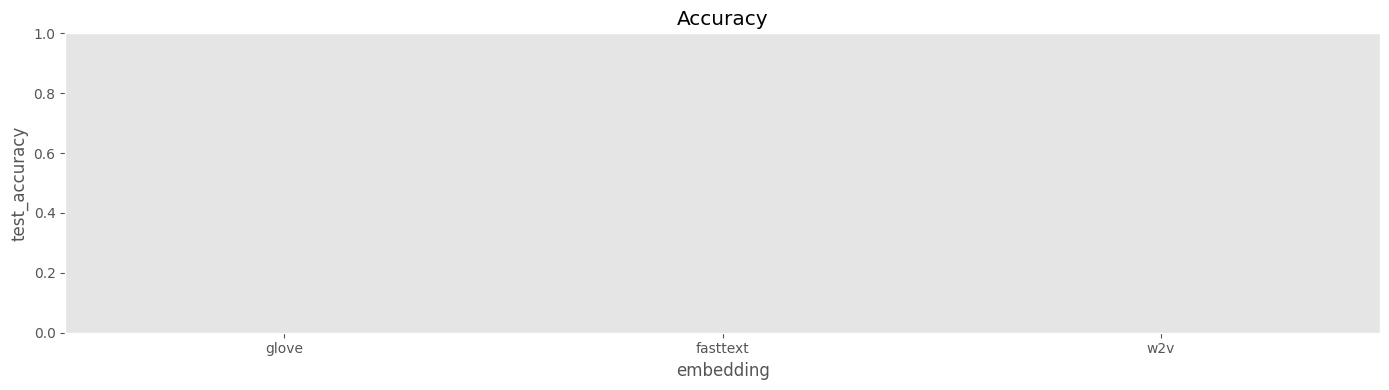

ValueError: Index contains duplicate entries, cannot reshape

<Figure size 1200x800 with 0 Axes>

In [58]:
def visualize_model_comparison(metric_names=None, run_filter=None):
    """
    Create advanced visualizations to compare models based on selected metrics.

    Parameters:
    -----------
    metric_names : list or None
        List of specific metric names to compare (e.g., ['test_accuracy', 'test_f1_score']).
        If None, uses default metrics: accuracy, precision, recall, f1_score, and roc_auc.
    run_filter : dict or None
        Dictionary of parameter name and values to filter runs (e.g., {'embedding': 'w2v'})
    """
    # Default metrics to visualize if none provided
    if not metric_names:
        metric_names = ['test_accuracy', 'test_precision', 'test_recall',
                        'test_f1_score', 'test_roc_auc']

    # Get metrics dataframe
    metrics_df = compare_run_metrics(run_filter=run_filter)

    # Filter for metrics we want to visualize
    available_metrics = [m for m in metric_names if m in metrics_df.columns]
    if not available_metrics:
        print("None of the requested metrics are available in the runs.")
        return

    # 1. Radar Chart / Spider Plot
    if len(available_metrics) >= 3 and len(metrics_df) >= 2:
        plt.figure(figsize=(12, 10))

        # Set up the radar chart
        categories = [m.replace('test_', '').replace('_', ' ').title() for m in available_metrics]
        N = len(categories)

        # Create angles for each metric
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]  # Close the loop

        # Set up subplot in polar projection
        ax = plt.subplot(111, polar=True)

        # Add lines for each embedding type
        embedding_types = metrics_df['embedding'].unique()
        colors = plt.cm.tab10(np.linspace(0, 1, len(embedding_types)))

        for i, embedding in enumerate(embedding_types):
            model_data = metrics_df[metrics_df['embedding'] == embedding]

            if len(model_data) == 0:
                continue

            # Get values for this model
            values = [model_data[metric].values[0] for metric in available_metrics]
            values += values[:1]  # Close the loop

            # Plot values
            ax.plot(angles, values, 'o-', linewidth=2, color=colors[i], label=embedding)
            ax.fill(angles, values, alpha=0.1, color=colors[i])

        # Set chart properties
        plt.xticks(angles[:-1], categories)
        ax.set_rlabel_position(0)
        plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ['0.2', '0.4', '0.6', '0.8', '1.0'],
                   color="grey", size=8)
        plt.ylim(0, 1)

        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
        plt.title('Model Comparison Across Metrics', size=15)

        # Save the radar chart
        radar_chart_path = "radar_chart_model_comparison.png"
        plt.tight_layout()
        plt.savefig(radar_chart_path)
        mlflow.log_artifact(radar_chart_path)
        plt.show()

    # 2. Bar chart comparison for each metric
    plt.figure(figsize=(14, 4 * len(available_metrics)))

    for i, metric in enumerate(available_metrics):
        plt.subplot(len(available_metrics), 1, i+1)

        # Sort for this specific metric
        sorted_df = metrics_df.sort_values(by=metric, ascending=False)

        # Create bar chart
        sns.barplot(x='embedding', y=metric, data=sorted_df)
        plt.title(f"{metric.replace('test_', '').replace('_', ' ').title()}")
        plt.ylim(0, 1)
        plt.grid(axis='y')

    plt.tight_layout()
    bar_chart_path = "bar_chart_model_comparison.png"
    plt.savefig(bar_chart_path)
    mlflow.log_artifact(bar_chart_path)
    plt.show()

    # 3. Heatmap for all metrics
    plt.figure(figsize=(12, 8))

    # Prepare data for heatmap - pivot table with embeddings as rows and metrics as columns
    pivot_data = []
    for _, row in metrics_df.iterrows():
        embedding = row['embedding']
        for metric in available_metrics:
            if metric in row:
                pivot_data.append({
                    'embedding': embedding,
                    'metric': metric.replace('test_', '').replace('_', ' ').title(),
                    'value': row[metric]
                })

    if pivot_data:
        pivot_df = pd.DataFrame(pivot_data)
        heatmap_df = pivot_df.pivot(index='embedding', columns='metric', values='value')

        # Plot heatmap
        sns.heatmap(heatmap_df, annot=True, cmap='YlGnBu', fmt='.3f')
        plt.title('Performance Metrics by Embedding Type')

        heatmap_path = "heatmap_model_comparison.png"
        plt.tight_layout()
        plt.savefig(heatmap_path)
        mlflow.log_artifact(heatmap_path)
        plt.show()

    return metrics_df

# Example usage
metrics_comparison = visualize_model_comparison()

# Example Usage for Model Comparison

Below are some examples of how to use the functions we've created to compare model performance across different runs.

In [ ]:
# Example 1: Get a basic comparison of all models
all_models_df = compare_run_metrics(
    metric_prefixes=['test_'],
    sort_by='test_accuracy',
    ascending=False
)
display(all_models_df)

In [ ]:
# Example 2: Create visualizations comparing different embedding types
visualize_model_comparison(['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score', 'test_roc_auc'])

In [59]:
# Example 4: Create a styled DataFrame with colored metrics based on performance
def style_dataframe(df, columns_to_style):
    """
    Apply conditional formatting to specific columns in the DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame to style
    columns_to_style : list
        List of column names to apply styling to

    Returns:
    --------
    pandas.io.formats.style.Styler
        Styled DataFrame
    """
    # Create a subset of the DataFrame with just the columns to style
    subset_df = df[columns_to_style].copy()

    # Define a function to color cells based on their values (higher is better)
    def color_scale(val):
        # For metrics where higher is better
        if pd.notnull(val):
            # Color from light yellow to dark green
            color_val = min(val * 2, 1.0)  # Scale value for better color spread
            r = int(255 * (1 - color_val))
            g = int(200 + 55 * color_val)
            b = int(100 * (1 - color_val))
            return f'background-color: rgb({r},{g},{b})'
        return ''

    # Apply the styling
    styled_df = df.style.apply(lambda x: [color_scale(val) if col in columns_to_style else ''
                                         for col, val in x.items()], axis=1)

    # Format metric columns to 4 decimal places
    format_dict = {col: '{:.4f}' for col in columns_to_style}
    styled_df = styled_df.format(format_dict)

    return styled_df

# Get metrics dataframe
metrics_df = compare_run_metrics(
    metric_prefixes=['test_'],
    sort_by='test_f1_score',
    ascending=False
)

# Define columns to style
metrics_to_style = [col for col in metrics_df.columns if col.startswith('test_')]

# Create styled dataframe
styled_metrics = style_dataframe(metrics_df, metrics_to_style)
display(styled_metrics)

,run_id,run_name,embedding,lstm_units,embedding_dim,epochs,max_length,test_accuracy,test_auc,test_specificity
0,2bc9842159d2492eaf5f8673a07beecc,bemused-moose-553,None,None,None,None,None,nan,nan,nan
1,29f1463d30e34065a4b6064fb5fc59e9,LSTM_glove_5epochs_128units,glove,128,100,5,100,nan,nan,nan
2,d876ae30831a417abeb61a77e6d4f695,LSTM_glove_5epochs_128units_model,None,None,None,None,None,0.7568,0.8414,0.7706
3,52e306e2772448c1849c419c74b25c16,LSTM_glove_5epochs_128units,glove,128,100,5,100,nan,nan,nan
4,d693a63906af4a5f978ff76b5ff7c195,LSTM_glove_5epochs_128units_model,None,None,None,None,None,nan,nan,nan
5,aa4696301cc74bd59a0316eac345e667,LSTM_glove_5epochs_128units_model,None,None,None,None,None,nan,nan,nan
6,74a884d7c23243688652947286030c54,LSTM_fasttext_5epochs_128units,fasttext,128,100,5,100,nan,nan,nan
7,3205b86fe0a946399d577bd4cb0c89ce,LSTM_fasttext_5epochs_128units_model,None,None,None,None,None,0.7181,0.7880,0.7228
8,2010b366dbbd4bbba3edf2c1d55d0342,LSTM_w2v_5epochs_128units,w2v,128,100,5,100,nan,nan,nan
9,c2dd5010f80c4740ad7899a449aff2a5,LSTM_w2v_5epochs_128units_model,None,None,None,None,None,0.6891,0.7549,0.6952


In [ ]:
# Example 5: Find the best model for each metric
def summarize_best_models(metric_prefixes=['test_']):
    """
    Create a summary of the best model for each metric.

    Parameters:
    -----------
    metric_prefixes : list
        List of metric prefixes to filter (e.g., ['test_', 'val_'])

    Returns:
    --------
    pandas.DataFrame
        DataFrame with best model for each metric
    """
    # Get metrics dataframe
    metrics_df = compare_run_metrics(metric_prefixes=metric_prefixes)

    if metrics_df.empty:
        return pd.DataFrame()

    # Find best model for each metric
    best_models = []

    # Get all metric columns
    metric_cols = [col for col in metrics_df.columns if any(col.startswith(prefix) for prefix in metric_prefixes)]

    for metric in metric_cols:
        # Skip non-numeric columns
        if not pd.api.types.is_numeric_dtype(metrics_df[metric]):
            continue

        # Find the row with the maximum value for this metric
        best_idx = metrics_df[metric].idxmax()
        best_row = metrics_df.loc[best_idx]

        best_models.append({
            'metric': metric,
            'best_value': best_row[metric],
            'embedding': best_row.get('embedding', 'unknown'),
            'run_name': best_row.get('run_name', 'unknown'),
            'run_id': best_row.get('run_id', 'unknown')
        })

    # Create summary dataframe
    summary_df = pd.DataFrame(best_models)
    summary_df = summary_df.sort_values(by='metric')

    return summary_df

# Get and display best model summary
best_models_summary = summarize_best_models()
display(best_models_summary)

In [ ]:
# Create a comparison of all model results
def create_model_comparison_summary():
    # Get client to query metrics
    client = MlflowClient()

    # Get all runs from our experiment
    experiment = mlflow.get_experiment_by_name(experiment_name)
    runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

    if len(runs) == 0:
        print("No runs found in the experiment")
        return

    # Extract key information for comparison
    comparison_data = []
    for _, run in runs.iterrows():
        run_id = run.run_id

        # Skip the run if it's just a comparison run
        if run.tags.run_name == "model_comparison":
            continue

        # Extract embedding type from run name
        run_name = run.tags.run_name
        embedding_type = run_name.split('_')[1] if '_' in run_name else "unknown"

        # Get metrics
        metrics = run.metrics
        test_metrics = {k: v for k, v in metrics.items() if k.startswith('test_')}

        # Add to comparison data
        run_info = {
            'run_id': run_id,
            'embedding': embedding_type,
            'run_name': run_name
        }
        run_info.update(test_metrics)
        comparison_data.append(run_info)

    # Create dataframe
    comparison_df = pd.DataFrame(comparison_data)

    # Create comparison visualizations
    if len(comparison_data) > 0 and len(comparison_data) > 1:
        plt.figure(figsize=(14, 8))

        # Plot key metrics
        metrics_to_plot = ['test_accuracy', 'test_roc_auc', 'test_f1_score']
        metrics_to_plot = [m for m in metrics_to_plot if m in comparison_df.columns]

        for i, metric in enumerate(metrics_to_plot):
            plt.subplot(1, len(metrics_to_plot), i+1)
            sns.barplot(x='embedding', y=metric, data=comparison_df)
            plt.title(f'{metric.replace("test_", "").capitalize()}')
            plt.ylim(0, 1.0)  # Set y-axis from 0 to 1
            plt.grid(True, axis='y')

        plt.tight_layout()
        plt.savefig("model_comparison_chart.png")

        # Save the comparison data
        comparison_df.to_csv("model_comparison_results.csv", index=False)

        # Log to MLflow in a new run
        with mlflow.start_run(run_name="model_comparison"):
            mlflow.log_artifact("model_comparison_chart.png")
            mlflow.log_artifact("model_comparison_results.csv")

        print("Model comparison completed and artifacts logged to MLflow")
    else:
        print("Not enough models to create comparison")

    return comparison_df

# Run the comparison after all models are trained
model_comparison = create_model_comparison_summary()
display(model_comparison)

# Finding Best Epoch for Each Run

The function below helps identify the optimal epoch for each model run based on specified metrics.

In [60]:
def get_best_epochs(metric_name='val_accuracy', optimization='max', embedding_types=None):
    """
    Analyzes the training history of each run and identifies the best epoch based on a specified metric.

    Parameters:
    -----------
    metric_name : str
        The name of the metric to optimize (e.g., 'val_accuracy', 'val_loss')
    optimization : str
        Whether to maximize ('max') or minimize ('min') the metric
    embedding_types : list or None
        Filter runs by embedding types (e.g., ['w2v', 'fasttext', 'glove'])

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the best epoch and corresponding metric value for each run
    """
    # Get client to query metrics
    client = MlflowClient()

    # Check if experiment exists
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        print(f"Error: Experiment '{experiment_name}' not found")
        return pd.DataFrame()

    # Get all runs from our experiment
    runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

    if len(runs) == 0:
        print("No runs found in the experiment")
        return pd.DataFrame()

    # Filter out comparison runs
    runs = runs[runs['tags.mlflow.runName'] != 'model_comparison']

    # Filter by embedding type if specified
    if embedding_types:
        filtered_runs = []
        for _, run in runs.iterrows():
            run_name = run['tags.mlflow.runName']
            for embedding in embedding_types:
                if embedding in run_name:
                    filtered_runs.append(run)
                    break
        runs = pd.DataFrame(filtered_runs) if filtered_runs else runs

    # Get best epoch for each run
    best_epochs = []

    for _, run in runs.iterrows():
        run_id = run['run_id']
        run_name = run['tags.mlflow.runName']

        # Extract embedding type from run name
        embedding_parts = run_name.split('_')
        embedding_type = embedding_parts[1] if len(embedding_parts) > 1 else "unknown"

        try:
            # Get metric history
            metric_history = client.get_metric_history(run_id, metric_name)

            if not metric_history:
                print(f"No {metric_name} data found for run: {run_name}")
                continue

            # Convert to DataFrame for easier analysis
            epochs = []
            values = []

            for item in metric_history:
                epochs.append(item.step)
                values.append(item.value)

            history_df = pd.DataFrame({
                'epoch': epochs,
                'value': values
            })

            # Find the best epoch based on optimization direction
            if optimization.lower() == 'max':
                best_idx = history_df['value'].idxmax()
            else:  # min
                best_idx = history_df['value'].idxmin()

            best_epoch = history_df.loc[best_idx, 'epoch']
            best_value = history_df.loc[best_idx, 'value']

            # Get other metrics at this epoch if available
            other_metrics = {}
            potential_metrics = ['val_loss', 'val_accuracy', 'train_loss', 'train_accuracy']

            for other_metric in potential_metrics:
                if other_metric != metric_name:
                    try:
                        other_history = client.get_metric_history(run_id, other_metric)
                        for item in other_history:
                            if item.step == best_epoch:
                                other_metrics[other_metric] = item.value
                                break
                    except:
                        pass

            # Create entry
            entry = {
                'run_id': run_id,
                'run_name': run_name,
                'embedding': embedding_type,
                'best_epoch': best_epoch,
                f'best_{metric_name}': best_value,
                'total_epochs': max(epochs) + 1  # +1 because epochs are 0-indexed
            }
            entry.update(other_metrics)

            best_epochs.append(entry)

        except Exception as e:
            print(f"Error processing run {run_name}: {e}")

    # Create dataframe
    if best_epochs:
        best_epochs_df = pd.DataFrame(best_epochs)

        # Sort by the optimized metric
        sort_col = f'best_{metric_name}'
        if sort_col in best_epochs_df.columns:
            if optimization.lower() == 'max':
                best_epochs_df = best_epochs_df.sort_values(by=sort_col, ascending=False)
            else:
                best_epochs_df = best_epochs_df.sort_values(by=sort_col)

        return best_epochs_df
    else:
        print("No valid runs found with the specified criteria")
        return pd.DataFrame()

# Example: Find best epochs based on validation accuracy
best_epochs_by_accuracy = get_best_epochs(metric_name='val_accuracy', optimization='max')
display(best_epochs_by_accuracy)

# Example: Find best epochs based on minimizing validation loss
best_epochs_by_loss = get_best_epochs(metric_name='val_loss', optimization='min')
display(best_epochs_by_loss)

No val_accuracy data found for run: bemused-moose-553
No val_accuracy data found for run: LSTM_glove_5epochs_128units_model
No val_accuracy data found for run: LSTM_glove_5epochs_128units_model
No val_accuracy data found for run: LSTM_glove_5epochs_128units_model
No val_accuracy data found for run: LSTM_fasttext_5epochs_128units_model
No val_accuracy data found for run: LSTM_w2v_5epochs_128units_model
No val_accuracy data found for run: LSTM_w2v_5epochs_128units_model
No val_accuracy data found for run: LSTM_w2v_5epochs_128units_model
No val_accuracy data found for run: LSTM_w2v_5epochs_128units_model
No val_accuracy data found for run: LSTM_w2v_5epochs_128units_model
No val_accuracy data found for run: LSTM_w2v_5epochs_128units_model
No val_accuracy data found for run: LSTM_w2v_5epochs_128units_model
No val_accuracy data found for run: LSTM_w2v_5epochs_128units_model
No val_accuracy data found for run: LSTM_w2v_5epochs_128units_model


,run_id,run_name,embedding,best_epoch,best_val_accuracy,total_epochs,val_loss,train_loss,train_accuracy
4,94ebec2f9bef412c8f38777f9d592e0a,LSTM_w2v_5epochs_128units,w2v,4,0.811500,5,0.427517,0.478890,0.768960
6,14f07c4330374f26bb38e5aa075aef69,LSTM_w2v_5epochs_128units,w2v,4,0.805000,5,0.431794,0.472045,0.774120
5,142521e57609499ba7f2be319e72b928,LSTM_w2v_5epochs_128units,w2v,4,0.803250,5,0.430828,0.482841,0.768580
7,66678ca23d0f4bf79369eb05574209ee,LSTM_w2v_5epochs_128units,w2v,4,0.795250,5,0.445012,0.492224,0.759640
1,52e306e2772448c1849c419c74b25c16,LSTM_glove_5epochs_128units,glove,3,0.769375,5,0.489022,0.407412,0.814313
0,29f1463d30e34065a4b6064fb5fc59e9,LSTM_glove_5epochs_128units,glove,2,0.766500,5,0.484394,0.450160,0.787719
2,74a884d7c23243688652947286030c54,LSTM_fasttext_5epochs_128units,fasttext,4,0.704000,5,0.561974,0.534061,0.729375
3,2010b366dbbd4bbba3edf2c1d55d0342,LSTM_w2v_5epochs_128units,w2v,4,0.689375,5,0.613900,0.480329,0.771563


No val_loss data found for run: bemused-moose-553
No val_loss data found for run: LSTM_glove_5epochs_128units_model
No val_loss data found for run: LSTM_glove_5epochs_128units_model
No val_loss data found for run: LSTM_glove_5epochs_128units_model
No val_loss data found for run: LSTM_fasttext_5epochs_128units_model
No val_loss data found for run: LSTM_w2v_5epochs_128units_model
No val_loss data found for run: LSTM_w2v_5epochs_128units_model
No val_loss data found for run: LSTM_w2v_5epochs_128units_model
No val_loss data found for run: LSTM_w2v_5epochs_128units_model
No val_loss data found for run: LSTM_w2v_5epochs_128units_model
No val_loss data found for run: LSTM_w2v_5epochs_128units_model
No val_loss data found for run: LSTM_w2v_5epochs_128units_model
No val_loss data found for run: LSTM_w2v_5epochs_128units_model
No val_loss data found for run: LSTM_w2v_5epochs_128units_model


,run_id,run_name,embedding,best_epoch,best_val_loss,total_epochs,val_accuracy,train_loss,train_accuracy
4,94ebec2f9bef412c8f38777f9d592e0a,LSTM_w2v_5epochs_128units,w2v,4,0.427517,5,0.811500,0.478890,0.768960
5,142521e57609499ba7f2be319e72b928,LSTM_w2v_5epochs_128units,w2v,4,0.430828,5,0.803250,0.482841,0.768580
6,14f07c4330374f26bb38e5aa075aef69,LSTM_w2v_5epochs_128units,w2v,4,0.431794,5,0.805000,0.472045,0.774120
7,66678ca23d0f4bf79369eb05574209ee,LSTM_w2v_5epochs_128units,w2v,4,0.445012,5,0.795250,0.492224,0.759640
1,52e306e2772448c1849c419c74b25c16,LSTM_glove_5epochs_128units,glove,2,0.479830,5,0.765750,0.448893,0.787906
0,29f1463d30e34065a4b6064fb5fc59e9,LSTM_glove_5epochs_128units,glove,2,0.484394,5,0.766500,0.450160,0.787719
2,74a884d7c23243688652947286030c54,LSTM_fasttext_5epochs_128units,fasttext,4,0.561974,5,0.704000,0.534061,0.729375
3,2010b366dbbd4bbba3edf2c1d55d0342,LSTM_w2v_5epochs_128units,w2v,3,0.598690,5,0.685625,0.526434,0.735125


No val_accuracy data found for run: bemused-moose-553
No val_accuracy data found for run: LSTM_glove_5epochs_128units_model
No val_accuracy data found for run: LSTM_glove_5epochs_128units_model
No val_accuracy data found for run: LSTM_glove_5epochs_128units_model
No val_accuracy data found for run: LSTM_fasttext_5epochs_128units_model
No val_accuracy data found for run: LSTM_w2v_5epochs_128units_model
No val_accuracy data found for run: LSTM_w2v_5epochs_128units_model
No val_accuracy data found for run: LSTM_w2v_5epochs_128units_model
No val_accuracy data found for run: LSTM_w2v_5epochs_128units_model
No val_accuracy data found for run: LSTM_w2v_5epochs_128units_model
No val_accuracy data found for run: LSTM_w2v_5epochs_128units_model
No val_accuracy data found for run: LSTM_w2v_5epochs_128units_model
No val_accuracy data found for run: LSTM_w2v_5epochs_128units_model
No val_accuracy data found for run: LSTM_w2v_5epochs_128units_model


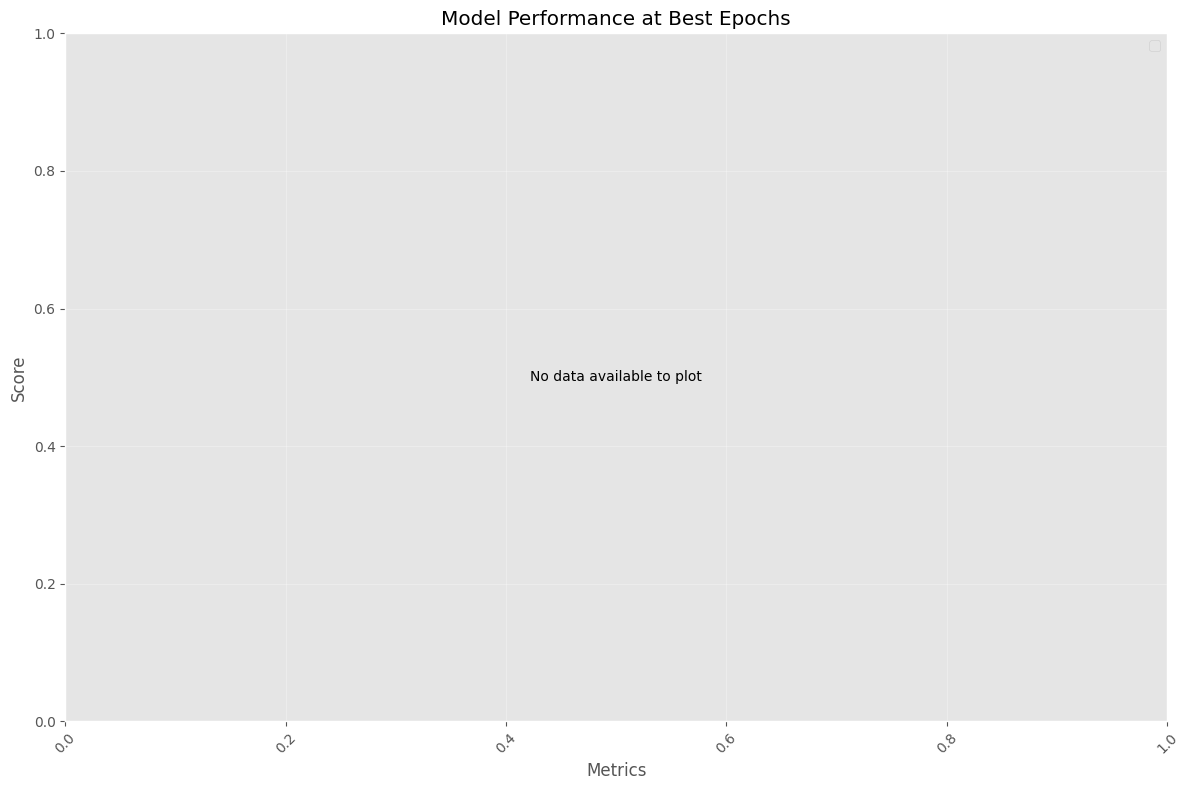

Model Comparison at Best Epochs:


,embedding,run_name,best_epoch,best_val_accuracy,total_epochs,val_loss,train_loss,train_accuracy,run_id
4,w2v,LSTM_w2v_5epochs_128units,4,0.811500,5,0.427517,0.478890,0.768960,94ebec2f9bef412c8f38777f9d592e0a
6,w2v,LSTM_w2v_5epochs_128units,4,0.805000,5,0.431794,0.472045,0.774120,14f07c4330374f26bb38e5aa075aef69
5,w2v,LSTM_w2v_5epochs_128units,4,0.803250,5,0.430828,0.482841,0.768580,142521e57609499ba7f2be319e72b928
7,w2v,LSTM_w2v_5epochs_128units,4,0.795250,5,0.445012,0.492224,0.759640,66678ca23d0f4bf79369eb05574209ee
1,glove,LSTM_glove_5epochs_128units,3,0.769375,5,0.489022,0.407412,0.814313,52e306e2772448c1849c419c74b25c16
0,glove,LSTM_glove_5epochs_128units,2,0.766500,5,0.484394,0.450160,0.787719,29f1463d30e34065a4b6064fb5fc59e9
2,fasttext,LSTM_fasttext_5epochs_128units,4,0.704000,5,0.561974,0.534061,0.729375,74a884d7c23243688652947286030c54
3,w2v,LSTM_w2v_5epochs_128units,4,0.689375,5,0.613900,0.480329,0.771563,2010b366dbbd4bbba3edf2c1d55d0342



Best Model for Each Metric:


,metric,best_model,best_value
0,test_accuracy,,0
1,test_precision,,0
2,test_recall,,0
3,test_f1_score,,0
4,test_roc_auc,,0
5,test_specificity,,0


In [63]:
def compare_models_at_best_epochs(metric_name='val_accuracy', optimization='max'):
    """
    Creates a comparison of model performance at their respective best epochs.

    Parameters:
    -----------
    metric_name : str
        The name of the metric to optimize (e.g., 'val_accuracy', 'val_loss')
    optimization : str
        Whether to maximize ('max') or minimize ('min') the metric

    Returns:
    --------
    pandas.DataFrame
        DataFrame with model performance metrics at their best epochs
    """
    # Get best epochs
    best_epochs_df = get_best_epochs(metric_name, optimization)

    if best_epochs_df.empty:
        print("No data available for comparison")
        return pd.DataFrame()

    # Get client to query metrics
    client = MlflowClient()

    # Metrics to compare
    comparison_metrics = [
        'test_accuracy', 'test_precision', 'test_recall', 'test_f1_score',
        'test_roc_auc', 'test_specificity'
    ]

    # Get metrics for each run at its best epoch
    for _, row in best_epochs_df.iterrows():
        run_id = row['run_id']

        # Get test metrics for this run
        run_data = mlflow.get_run(run_id).data
        for metric in comparison_metrics:
            if metric in run_data.metrics:
                best_epochs_df.loc[_, metric] = run_data.metrics[metric]

    # Reorder columns for better readability
    cols_order = ['embedding', 'run_name', 'best_epoch', f'best_{metric_name}', 'total_epochs'] + \
                 [c for c in best_epochs_df.columns if c.startswith('train_') or c.startswith('val_')] + \
                 comparison_metrics + \
                 [c for c in best_epochs_df.columns if c not in ['embedding', 'run_name', 'best_epoch',
                                                               f'best_{metric_name}', 'total_epochs'] and
                                                     not c.startswith('train_') and
                                                     not c.startswith('val_') and
                                                     c not in comparison_metrics]

    # Keep only columns that exist
    cols_order = [c for c in cols_order if c in best_epochs_df.columns]

    # Create a styled dataframe
    comparison_df = best_epochs_df[cols_order].copy()

    # Find the best model for each metric
    best_model_summary = pd.DataFrame({
        'metric': comparison_metrics,
        'best_model': [''] * len(comparison_metrics),
        'best_value': [0] * len(comparison_metrics)
    })

    for i, metric in enumerate(comparison_metrics):
        if metric in comparison_df.columns:
            idx_best = comparison_df[metric].idxmax()
            if pd.notnull(idx_best):
                best_model = comparison_df.loc[idx_best, 'embedding']
                best_value = comparison_df.loc[idx_best, metric]
                best_model_summary.loc[i, 'best_model'] = best_model
                best_model_summary.loc[i, 'best_value'] = best_value

    # Create visualization of best model performance
    plt.figure(figsize=(12, 8))
    for i, embedding in enumerate(comparison_df['embedding'].unique()):
        model_data = []
        available_metrics = []
        for metric in comparison_metrics:
            if metric in comparison_df.columns:
                value = comparison_df[comparison_df['embedding'] == embedding][metric].values
                if len(value) > 0:
                    model_data.append(value[0])
                    available_metrics.append(metric)
                else:
                    model_data.append(0)
                    available_metrics.append(metric)

        #  Only plot if we have data
        if len(model_data) > 0:
            plt.plot(available_metrics, model_data, marker='o', label=embedding)

    if len(plt.gca().get_lines()) == 0:
        plt.text(0.5, 0.5, "No data available to plot",
                horizontalalignment='center', verticalalignment='center',
                transform=plt.gca().transAxes)
    plt.title('Model Performance at Best Epochs')
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the plot
    plot_path = "model_performance_at_best_epochs.png"
    plt.savefig(plot_path)

    # Log to MLflow
    try:
        with mlflow.start_run(run_name="best_epochs_comparison"):
            mlflow.log_artifact(plot_path)
    except Exception as e:
        print(f"Warning: Could not log artifact to MLflow: {e}")

    plt.show()

    return comparison_df, best_model_summary

# Example: Compare models at their best epochs
comparison_df, best_model_summary = compare_models_at_best_epochs()

# Display the results
print("Model Comparison at Best Epochs:")
display(comparison_df)

print("\nBest Model for Each Metric:")
display(best_model_summary)